# ARMA-GARCH Modeling for INTC Stock Returns
## Analyzing Autocorrelations, Volatility Clustering, and Distributional Assumptions
### Names: Duc Minh Nguyen, Tudor Ungureanu



## Introduction
- **Objective**: Analyze daily log-returns of INTC stock.
- **Focus**: Autocorrelations, volatility clustering, and distributional assumptions.


In [1]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 10.1 MB/s eta 0:00:00


In [2]:
pip install --upgrade yfinance

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from arch import arch_model
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
from scipy.stats import t
from scipy.stats import chi2, norm


# Download data
ticker = "INTC"
df = yf.download(ticker, period="33y")
df["log_return"] = 100*np.log(df["Close"]/df["Close"].shift(1))
df = df.dropna()

df


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,log_return
Ticker,INTC,INTC,INTC,INTC,INTC,
Date,,,,,,
1992-02-25,1.110778,1.136914,1.097710,1.130380,86969600,-2.517004
1992-02-26,1.141269,1.145626,1.110778,1.115133,75641600,2.708022
1992-02-27,1.123846,1.154338,1.123846,1.141270,47635200,-1.538452
1992-02-28,1.106423,1.132559,1.097711,1.128203,30563200,-1.562458
1992-03-02,1.145626,1.147803,1.102066,1.106421,49091200,3.481887
...,...,...,...,...,...,...
2025-02-14,23.600000,25.190001,22.860001,24.360001,230254100,-2.220912
2025-02-18,27.389999,27.549999,24.490000,24.600000,284292200,14.893123


#Part 1


# Data Analysis


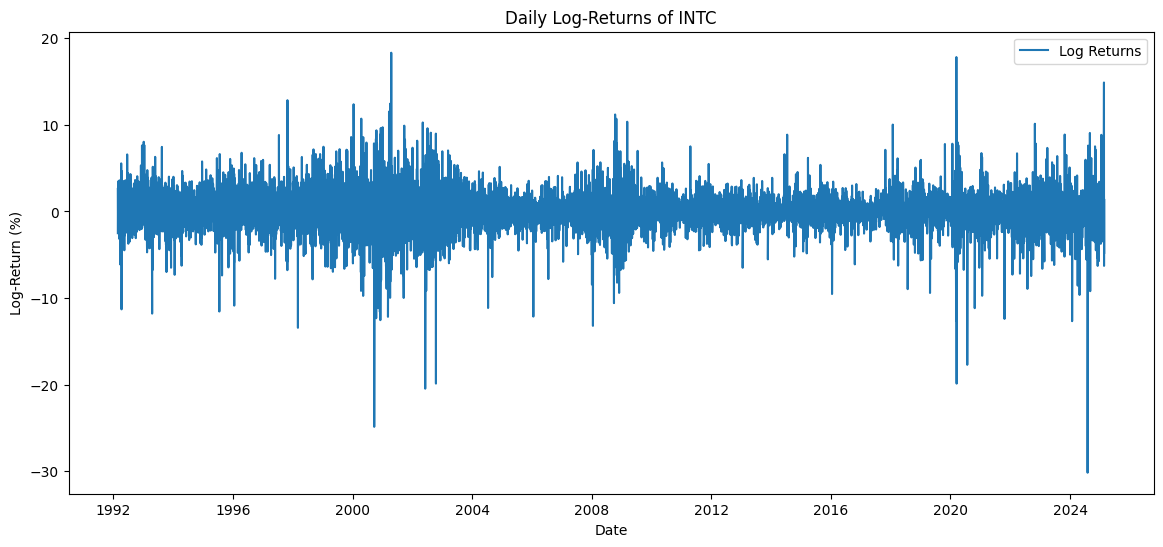

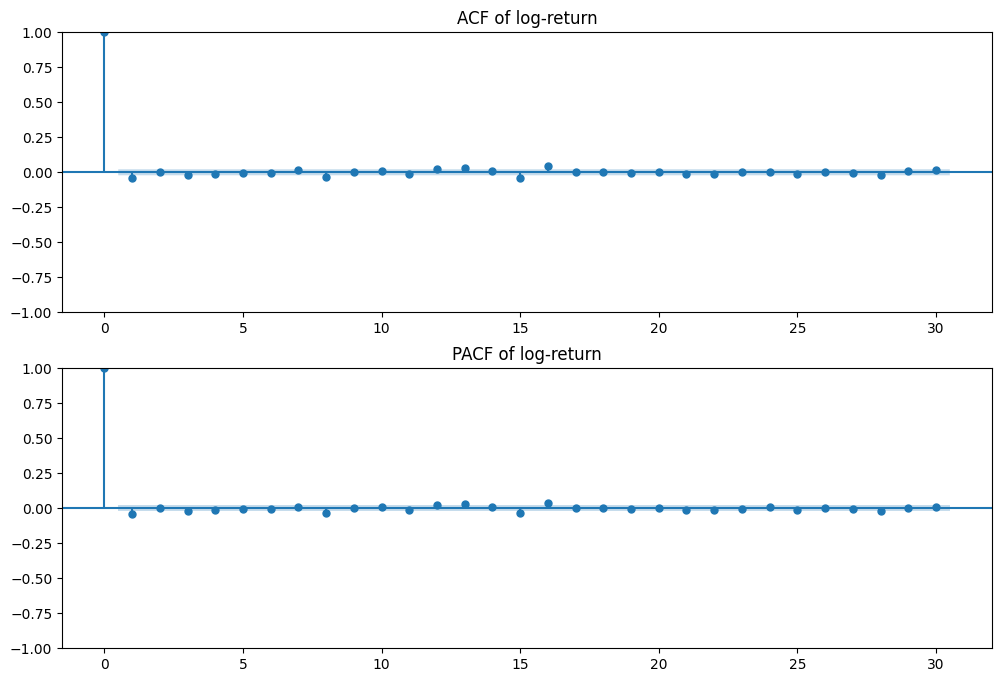

In [4]:
# Plotting log-return
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['log_return'], label='Log Returns')
plt.title('Daily Log-Returns of INTC')
plt.xlabel('Date')
plt.ylabel('Log-Return (%)')
plt.legend()
plt.show()

 # ACF and PACF
fig, ax = plt.subplots(2, 1, figsize=(12, 8), )
plot_acf(df['log_return'],  lags=30, ax=ax[0], title = "ACF of log-return")
plot_pacf(df['log_return'], lags=30, ax=ax[1], title = "PACF of log-return")
plt.show()


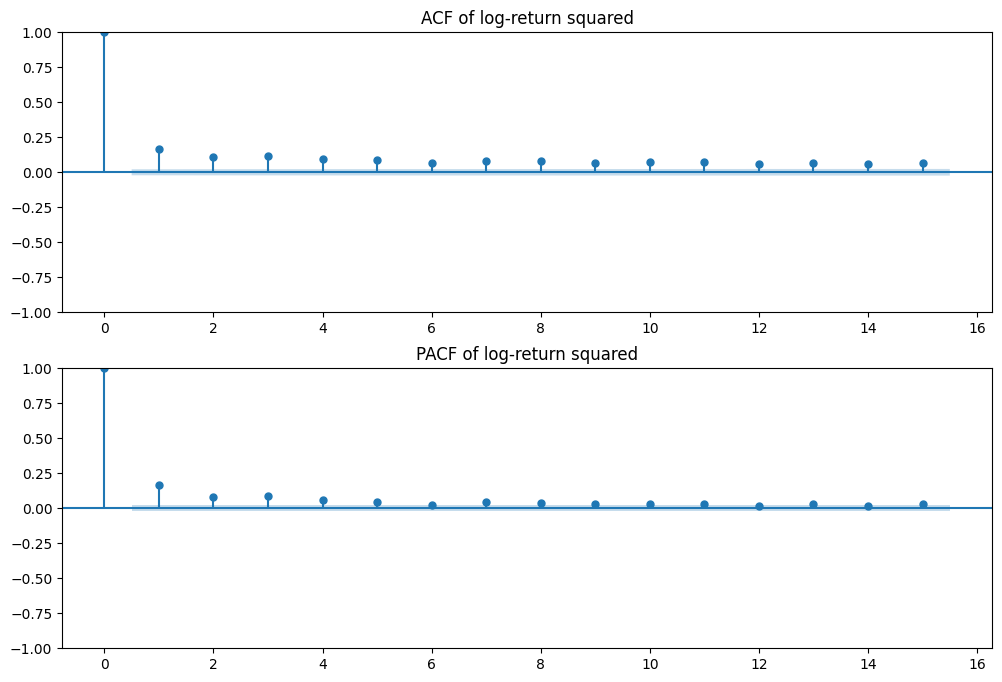

In [5]:
# Plotting acf and pacf of log-return squared
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['log_return']**2, lags=15, ax=ax[0],  title = "ACF of log-return squared")
plot_pacf(df['log_return']**2, lags=15, ax=ax[1],  title = "PACF of log-return squared")
plt.show()

<ipython-input-6-a4a6c57c38d4>:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


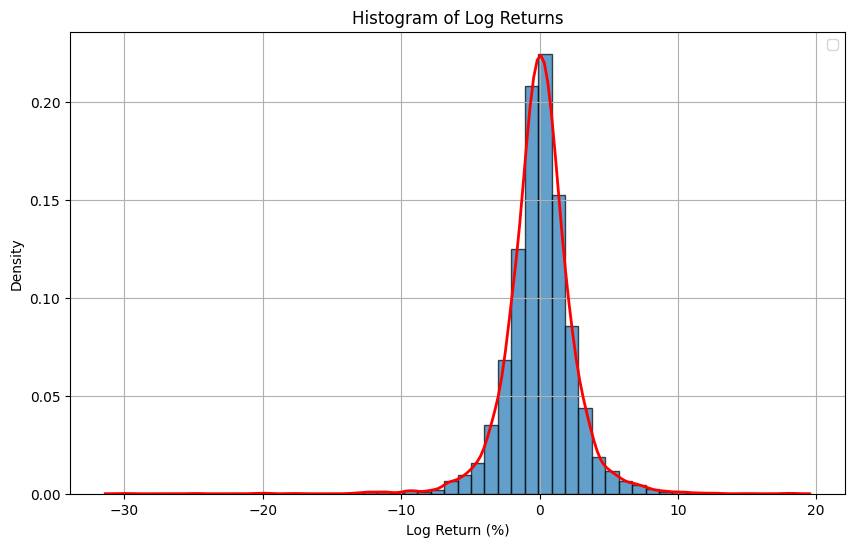

In [6]:
## Plotting histogram of log-return
plt.figure(figsize=(10, 6))
plt.hist(df['log_return'], bins=50, edgecolor='black', alpha=0.7, density=True)
plt.title('Histogram of Log Returns')
plt.xlabel('Log Return (%)')
plt.ylabel('Density')
plt.grid(True)

# cverlay a normal distribution curve for comparison
import seaborn as sns
sns.kdeplot(df['log_return'], color='red', linewidth=2)
plt.legend()

plt.show()

## Model Selection
- **ARMA Model**: Based on ACF and PACF plots.
- **GARCH Model**: Needed due to volatility clustering.
- **Combinations Tested**: Various AR-GARCH combinations.


In [7]:
# Define a range of ARMA and GARCH orders to test
ar_orders = [1,2,3, 4, 5]
garch_orders = [(1, 0), (1, 1), (2, 0), (2, 1), (1,2), (2,2)]

# Computing BIC
results = []
for p in ar_orders:
    for garch_order in garch_orders:

            model = arch_model(df['log_return'], mean='AR', lags=p, vol='GARCH', p=garch_order[0], q=garch_order[1], dist='normal').fit(disp='off')

            results.append({
                'AR Order': p,
                'GARCH Order': garch_order,
                'BIC': model.bic
            })


results_df = pd.DataFrame(results)

# Sort by BIC
results_df = results_df.sort_values(by=['BIC'])

print(results_df)


    AR Order GARCH Order           BIC
4          1      (1, 2)  36415.184091
10         2      (1, 2)  36418.873600
16         3      (1, 2)  36422.690846
5          1      (2, 2)  36424.208945
22         4      (1, 2)  36425.601429
1          1      (1, 1)  36427.524772
11         2      (2, 2)  36427.898333
28         5      (1, 2)  36428.571000
7          2      (1, 1)  36431.466461
17         3      (2, 2)  36431.715458
23         4      (2, 2)  36434.625925
13         3      (1, 1)  36435.213486
3          1      (2, 1)  36436.549626
29         5      (2, 2)  36437.595373
19         4      (1, 1)  36437.988835
9          2      (2, 1)  36440.491194
25         5      (1, 1)  36441.024449
15         3      (2, 1)  36444.239771
21         4      (2, 1)  36447.013408
27         5      (2, 1)  36450.048872
2          1      (2, 0)  37216.522275
14         3      (2, 0)  37219.918396
8          2      (2, 0)  37220.793984
20         4      (2, 0)  37224.569681
26         5      (2, 0) 

In [8]:
best_model = results_df.iloc[0]

best_ar_order = best_model['AR Order']
best_garch_order = best_model['GARCH Order']
print(best_ar_order, best_garch_order)

1 (1, 2)


##Testing

In [9]:
# Step 4: Model Estimation
#  extract residuals
ar_garch_model = arch_model(df['log_return'], mean='AR', lags=best_ar_order, vol='GARCH', p=best_garch_order[0], q=best_garch_order[1], dist='normal').fit(disp='off')

residuals = ar_garch_model.resid
residuals.dropna(inplace=True)

# Step 5: model Diagnostics
# Ljung-Box Test
lb_test = acorr_ljungbox(residuals, lags=[10], return_df=True)
print("Ljung-Box Test p-value:", lb_test)

# ARCH-LM Test
arch_test = het_arch(residuals, maxlag=10)
print("ARCH-LM Test p-values:", arch_test[1])

# Jarque-Bera test
jarque_bera_test = stats.jarque_bera(residuals)
print("Jarque-Bera Test p-value:", jarque_bera_test.pvalue)


Ljung-Box Test p-value:       lb_stat  lb_pvalue
10  22.320188   0.013554
ARCH-LM Test p-values: 6.752000290133057e-89
Jarque-Bera Test p-value: 0.0


<ipython-input-9-5a1a6d571f94>:14: FutureWarning: the 'maxlag' keyword is deprecated, use 'nlags' instead.
  arch_test = het_arch(residuals, maxlag=10)


In [10]:
ar_garch_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           AR - GARCH Model Results                           
==============================================================================
Dep. Variable:             log_return   R-squared:                       0.001
Mean Model:                        AR   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -18180.5
Distribution:                  Normal   AIC:                           36373.0
Method:            Maximum Likelihood   BIC:                           36415.2
                                        No. Observations:                 8307
Date:                Sun, Feb 23 2025   Df Residuals:                     8305
Time:                        22:37:19   Df Model:                            2
                                   Mean Model                                   
================================================================================
                    coef    std err          t      P>|t|       95.0% Conf. Int.
--------------------------------------------------------------------------------
Const             0.0547  2.152e-02      2.543  1.099e-02  [1.254e-02,9.689e-02]
log_return[1]    -0.0132  1.405e-02     -0.940      0.347 [-4.076e-02,1.433e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.0415  3.064e-02      1.353      0.176 [-1.860e-02,  0.102]
alpha[1]       0.0548  2.380e-02      2.303  2.130e-02  [8.157e-03,  0.101]
beta[1]        0.3225      0.104      3.087  2.022e-03    [  0.118,  0.527]
beta[2]        0.6169      0.109      5.670  1.428e-08    [  0.404,  0.830]
===========================================================================

Covariance estimator: robust
"""

## Addendum: Recent Developments and Impact on INTC Stock Price
Recent reports from The Wall Street Journal suggest potential strategic shifts for Intel Corporation (INTC). Broadcom has shown interest in Intel’s chip design operations, and Taiwan Semiconductor Manufacturing Company (TSMC) may be considering Intel’s chip plants. Although these discussions are in early stages, they could significantly impact Intel's future and its stock volatility.

Past Performance

Intel's stock has faced a challenging trajectory, with a decline of over 64% in the past five years, contrasting sharply with the S&P 500's 81% increase in the same period. This decline reflects strategic missteps, such as entering the mobile chip market late and missing opportunities in AI chips, allowing competitors like Nvidia to dominate.

Effect on Volatility and ARMA-GARCH Modeling

The news of potential interest in Intel's assets could introduce heightened volatility in its stock price. Such developments often lead to increased market speculation and trading activity, which can affect the autocorrelation structure and volatility clustering modeled by ARMA-GARCH frameworks. Investors should closely monitor these developments, as they may necessitate adjustments in modeling approaches to accurately capture the evolving dynamics of Intel's stock.



# Reestimation with t-distributed error

In [11]:
### model with t-distribution
#  extract residuals
new_argarch_model = arch_model(df['log_return'], mean='AR', lags=best_ar_order, vol='GARCH', p=best_garch_order[0], q=best_garch_order[1], dist='t').fit(disp='off')

t_residuals = new_argarch_model.resid
t_residuals.dropna(inplace=True)

# Step 5: model Diagnostics
# Ljung-Box Test
lb_test = acorr_ljungbox(t_residuals, lags=[10], return_df=True)
print("Ljung-Box Test p-value:", lb_test)

# ARCH-LM Test
arch_test = het_arch(t_residuals, maxlag=10)
print("ARCH-LM Test p-values:", arch_test[1])

# Jarque-Bera test
jarque_bera_test = stats.jarque_bera(t_residuals)
print("Jarque-Bera Test p-value:", jarque_bera_test.pvalue)

Ljung-Box Test p-value:       lb_stat  lb_pvalue
10  24.814625   0.005708
ARCH-LM Test p-values: 3.184207298323651e-89
Jarque-Bera Test p-value: 0.0


<ipython-input-11-a7f18a8896ae>:14: FutureWarning: the 'maxlag' keyword is deprecated, use 'nlags' instead.
  arch_test = het_arch(t_residuals, maxlag=10)


In [12]:
new_argarch_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              AR - GARCH Model Results                              
====================================================================================
Dep. Variable:                   log_return   R-squared:                       0.000
Mean Model:                              AR   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -17670.6
Distribution:      Standardized Student's t   AIC:                           35355.3
Method:                  Maximum Likelihood   BIC:                           35404.5
                                              No. Observations:                 8307
Date:                      Sun, Feb 23 2025   Df Residuals:                     8305
Time:                              22:37:20   Df Model:                            2
                                    Mean Model                                   
=================================================================================
                     coef    std err          t      P>|t|       95.0% Conf. Int.
---------------------------------------------------------------------------------
Const              0.0748  1.854e-02      4.034  5.472e-05    [3.845e-02,  0.111]
log_return[1] -8.2230e-03  1.092e-02     -0.753      0.451 [-2.963e-02,1.318e-02]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0168  7.572e-03      2.215  2.675e-02 [1.933e-03,3.162e-02]
alpha[1]       0.0504  1.026e-02      4.913  8.987e-07 [3.031e-02,7.055e-02]
beta[1]        0.6147      0.237      2.599  9.356e-03     [  0.151,  1.078]
beta[2]        0.3333      0.230      1.451      0.147     [ -0.117,  0.784]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.2210      0.310     16.851  1.040e-63 [  4.614,  5.828]
========================================================================

Covariance estimator: robust
"""

#Part 2

### Calculating the Best Model on the Estimation Period

In [13]:
# Historical Simulation for VaR (rolling 250-day window)
df['VaR_Historical'] = df['log_return'].rolling(window=250).quantile(0.01)

# estimation and evaluation periods
estimation_df = df.loc["1992-02-20":"2016-12-31"]
evaluation_df =  df.loc["2017-01-01":"2024-12-31"]

# Define candidate orders for AR and GARCH components
ar_orders = range(1, 4)  ## try AR(1) to AR(3)
garch_orders = [(1, 1), (1, 2), (2, 1), (2, 2)]  # Try different (p, q) combinations
# Step 1: Select the Best AR-GARCH Model Using BIC
results = []
for p in ar_orders:
    for garch_order in garch_orders:
            model = arch_model(estimation_df['log_return'], mean='AR', lags=p, vol='GARCH',
                               p=garch_order[0], q=garch_order[1], dist='normal')
            fitted_model = model.fit(disp='off')

            results.append({
                'AR Order': p,
                'GARCH Order': garch_order,
                'BIC': fitted_model.bic,
                'Model': fitted_model  #  store the model
            })


# Select the best model (lowest BIC)
best_model_info = min(results, key=lambda x: x['BIC'])
best_model = best_model_info['Model']
print(f"Selected AR({best_model_info['AR Order']})-GARCH{best_model_info['GARCH Order']} model with BIC: {best_model_info['BIC']}")

print(best_ar_order)
print(best_garch_order)

Selected AR(1)-GARCH(1, 1) model with BIC: 27208.67984318304
1
(1, 2)


### VAR Computing and Historical Simulation and Comaprison

<ipython-input-14-64e090ee8105>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df.loc[index,  'mu_t'] = mean_value
<ipython-input-14-64e090ee8105>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  evaluation_df.loc[index, 'sigma_t'] = np.sqrt(variance_value)
<ipython-input-14-64e090ee8105>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

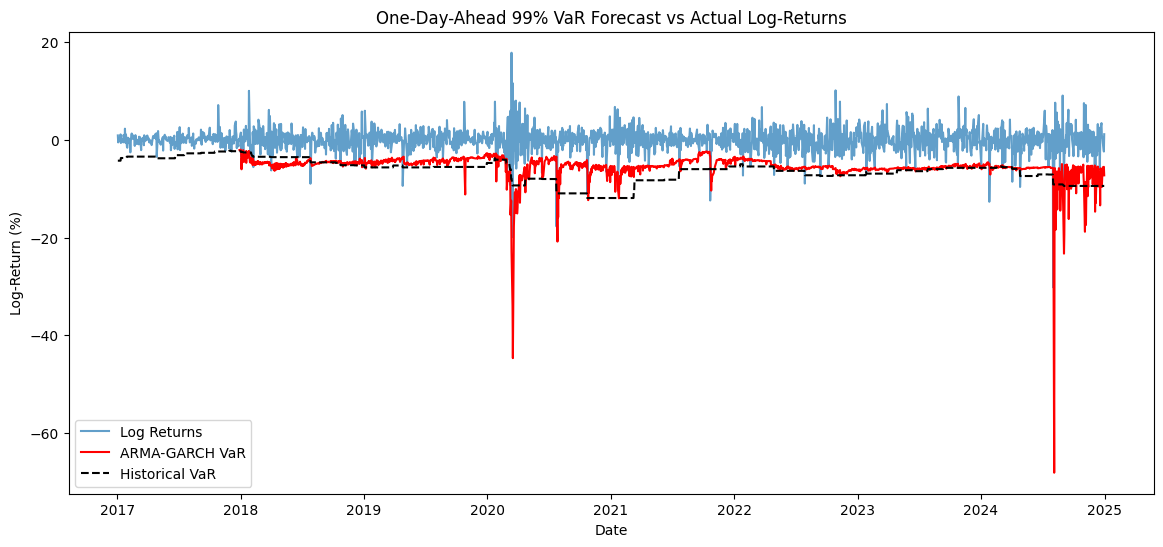

In [14]:
# Rolling estimation
window_size = 250  # Define rolling window size

for i in range(len(evaluation_df) - window_size):
    train_data = evaluation_df['log_return'].iloc[i:i+window_size]

    # Fit AR-GARCH on rolling window
    ar_garch_model = arch_model(train_data, mean='AR', lags=best_ar_order,
                                vol='GARCH', p=best_garch_order[0], q=best_garch_order[1], dist='normal').fit(disp='off')

    index = evaluation_df.index[i+window_size]
    forecasts =  ar_garch_model.forecast(horizon=1, reindex=False)

    mean_value = forecasts.mean.iloc[-1, 0]
    variance_value = forecasts.variance.iloc[-1, 0]

    evaluation_df.loc[index,  'mu_t'] = mean_value
    evaluation_df.loc[index, 'sigma_t'] = np.sqrt(variance_value)

#  99% quantile for standard normal distribution
z_q = norm.ppf(0.01)

# Compute AR-GARCH based 1-day VaR
evaluation_df['VaR_GARCH'] = evaluation_df['mu_t'] + evaluation_df['sigma_t']*z_q


#
plt.figure(figsize=(14, 6))
plt.plot(evaluation_df.index, evaluation_df['log_return'], label='Log Returns', alpha=0.7)
plt.plot(evaluation_df.index, evaluation_df['VaR_GARCH'], label='ARMA-GARCH VaR', color='red')
plt.plot(evaluation_df.index, evaluation_df['VaR_Historical'], label='Historical VaR', color='black', linestyle='--')
plt.title('One-Day-Ahead 99% VaR Forecast vs Actual Log-Returns')
plt.xlabel('Date')
plt.ylabel('Log-Return (%)')
plt.legend()
plt.show()

##Testing

### Basel Binomial Test

In [15]:
# Basel Traffic Light Test
def basel_traffic_light_test(num_exceedances, n=250, alpha=0.99):
    p = 1 - alpha
    expected_exceedances = n*p
    prob_exceedances = stats.binom.cdf( num_exceedances, n, p)

    if num_exceedances <= 4:
        return "Green Zone: Model performs well."
    elif 5 <= num_exceedances <= 9:
        return "Yellow Zone: Model is questionable."
    else:
        return "Red Zone: Model likely misspecified."

### Christoffersen's Independence Test

In [16]:
def christoffersen_independence_test(violations):
    v00, v01, v10, v11 = 0, 0 , 0, 0
    for i in range(1, len(violations)):
        if violations[i-1] == 0 and violations[i] == 0:
            v00 += 1
        elif violations[i-1] == 0  and violations[i] == 1:
            v01 += 1
        elif violations[i-1] == 1 and violations[i]== 0:
            v10 += 1
        elif violations[i - 1] == 1 and violations[i]==1:
            v11 += 1

    p0 = v01/(v00 + v01) if (v00 + v01) > 0 else 0
    p1 = v11/(v10 + v11) if (v10 + v11) > 0 else 0
    p = (v01+v11)/(v00 + v01 + v10 + v11)

    likelihood_ratio = -2*(np.log((p**(v01+ v11)*(1-p)**(v00 + v10))) -
                             np.log((p0**v01*(1-p0)**v00) + (p1**v11*(1-p1)**v10)))
    p_value = 1 - chi2.cdf(likelihood_ratio, df=1)
    return likelihood_ratio, p_value

###Kupiec's POF Test

In [17]:
def kupiec_pof_test(returns, var, alpha=0.99):
    n = len(returns)
    num_exceedances = np.sum(returns < var)
    p_hat = num_exceedances / n
    likelihood_ratio = -2*(np.log((1 - alpha)**(n-num_exceedances)*(alpha**num_exceedances)) -
                             np.log((1- p_hat) ** (n-num_exceedances)*(p_hat**num_exceedances)))
    p_value = 1 - chi2.cdf(likelihood_ratio, df=1)
    return num_exceedances, likelihood_ratio, p_value


###Performing the Tests

In [18]:
# Perform Backtests
def perform_backtests(df):
    results  = {}
    for var_type in ['VaR_Historical', 'VaR_GARCH']:
        print(f"\nBacktest results for {var_type}:")
        returns = df['log_return']
        var = df[var_type]
        exceedances = (returns < var).astype(int)
        num_exceedances = exceedances.sum()

        # Basel Traffic Light Test
        basel_result = basel_traffic_light_test( num_exceedances, n=len(df) )
        print(f"Basel Traffic Light Test: {basel_result}" )

        # Kupiec POF Test
        num_exceed, kupiec_lr, kupiec_p = kupiec_pof_test(returns, var)
        print(f"Kupiec POF Test: Exceedances={num_exceed}, LR={kupiec_lr:.4f}, p-value={kupiec_p:.4f}")

        # Christoffersen Independence Test
        christoffersen_lr, christoffersen_p = christoffersen_independence_test(exceedances)
        print(f"Christoffersen Independence Test:  LR={christoffersen_lr:.4f},  p-value={christoffersen_p:.4f}")

        results[var_type] = {
            'Basel Test': basel_result,
            'Kupiec POF': (num_exceed, kupiec_lr, kupiec_p),
            'Christoffersen': (christoffersen_lr, christoffersen_p),
        }
    return results

# run Backtests
backtest_results = perform_backtests(evaluation_df)



Backtest results for VaR_Historical:
Basel Traffic Light Test: Red Zone: Model likely misspecified.
Kupiec POF Test: Exceedances=25, LR=inf, p-value=0.0000
Christoffersen Independence Test:  LR=260.6663,  p-value=0.0000

Backtest results for VaR_GARCH:
Basel Traffic Light Test: Red Zone: Model likely misspecified.
Kupiec POF Test: Exceedances=40, LR=inf, p-value=0.0000
Christoffersen Independence Test:  LR=392.5997,  p-value=0.0000


<ipython-input-17-e1e445a9f44f>:5: RuntimeWarning: divide by zero encountered in log
  likelihood_ratio = -2*(np.log((1 - alpha)**(n-num_exceedances)*(alpha**num_exceedances)) -
<ipython-input-16-3376d5d10222>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if violations[i-1] == 0 and violations[i] == 0:
<ipython-input-16-3376d5d10222>:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif violations[i-1] == 0  and violations[i] == 1:
<ipython-input-16-3376d5d10222>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consis